In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import scanpy as sc
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

# Evaluation metrics
from sklearn.metrics import (homogeneity_score,v_measure_score,adjusted_mutual_info_score,normalized_mutual_info_score,adjusted_rand_score,fowlkes_mallows_score)

# Import SpaLP modules    Python package: https://github.com/dbjzs/SpaLP
from SpaLP.LP import SpatialLocalPooling
from SpaLP.utils import set_seed, prepare_inputs
# Set random seed
set_seed(7)

#Check the GPU memory and CPU memory
import memory_profiler  # pip install memory_profiler
import torch
import gc

# Check device
import cpuinfo   # pip install py-cpuinfo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
info = cpuinfo.get_cpu_info()
print("CPU:", info['brand_raw'])

Using device: cuda
GPU: NVIDIA A800-SXM4-80GB
CPU: Intel(R) Xeon(R) Platinum 8462Y+


In [2]:
#Check the GPU memory and CPU memory
from memory_profiler import memory_usage
def measure_resources(func):
    def wrapper(*args, **kwargs):
        gc.collect()
        torch.cuda.synchronize()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        
        before = memory_usage(-1, interval=0.1, timeout=1)[0]
        mem_peak, result = memory_usage((func, args, kwargs),max_usage=True,retval=True)
        print(f"CPU peak memory: {(mem_peak - before)/1024:.2f} GB")
        
        torch.cuda.synchronize()
        gpu_peak = torch.cuda.max_memory_allocated() / 1024**3
        print(f"GPU peak memory: {gpu_peak:.2f} GB")
        return result
    return wrapper

In [3]:
def train_spalp(graph, in_channels, hidden_dim, epochs, lr, device,seed):
    """Train SpaLP model and return embeddings."""
    from tqdm.auto import tqdm
    set_seed(seed)
    pbar = tqdm(range(epochs), desc="Training",ncols=200)
    model = SpatialLocalPooling(in_channels, hidden_dim).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    losses = []
    
    for epoch in pbar:
        start_time = time.time()
        model.train()
        optimizer.zero_grad()
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        loss = criterion(reconstructed, graph.features)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        elapsed = time.time() - start_time
        pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})
    
    # Get final embeddings
    model.eval()
    with torch.no_grad():
        reconstructed,embedding = model(graph.features, graph.neighbor_idx)
        reconstructed = reconstructed.cpu().numpy()
        embedding=embedding.cpu().numpy()
    return embedding, losses

# Dataset 1: Within-platform integration (STARmap PLUS)

In [4]:
# Load STARmap PLUS data
import anndata as ad
adata_batch1 = sc.read_h5ad('/home/dbj/SpaLA/STARmap/starmap_plus_mouse_cns_batch1.h5ad')
adata_batch2 = sc.read_h5ad('/home/dbj/SpaLA/STARmap/starmap_plus_mouse_cns_batch2.h5ad')
adata_batch3 = sc.read_h5ad('/home/dbj/SpaLA/STARmap/starmap_plus_mouse_cns_batch3.h5ad')
adata_list=[adata_batch1,adata_batch2,adata_batch3]
adata = ad.concat(adata_list, join="inner")

In [5]:
# Preprocessing standardization  *******
start_time = time.time()
adatas = []
for batch in adata.obs['batch'].unique():  #Preprocess each slice independently and then merge them.
    a = adata[adata.obs['batch'] == batch].copy()
    sc.pp.normalize_total(a, inplace=True)
    sc.pp.log1p(a)
    sc.pp.scale(a)
    adatas.append(a)
adata = ad.concat(adatas, join="inner")
adata.obsm['feat']=adata.X
prep_time = time.time() - start_time

print(f"Spatial coords shape: {adata.obsm['spatial'].shape}")
print(f"Preprocessing standardization: {prep_time:.2f}s")

Spatial coords shape: (422673, 2)
Preprocessing standardization: 4.21s


In [6]:
# Set the hyperparameters  k=6
k=6
in_channels = adata.obsm['feat'].shape[1]
lr=0.001
epochs = 200
hidden_dim=64
print(f"Feature dimensions: {in_channels}")

Feature dimensions: 1022


In [7]:
# Build neighbor graph  k=6
from SpaLP.utils import Graph
start_time = time.time()
#compute a separate spatial neighbor index matrix for each sample
graphs = []
for batch in adata.obs['batch'].unique():  #compute a separate spatial neighbor index matrix for each sample and combine them as disconnected components.
    a = adata[adata.obs['batch'] == batch].copy()
    graph = prepare_inputs(a, k=k, device=device)
    graphs.append(graph)

# combine disconnected components.
all_features = torch.cat([g.features for g in graphs], dim=0)
all_neighbor_idx = []
offset = 0
for g in graphs:
    all_neighbor_idx.append(g.neighbor_idx + offset)
    offset += g.features.shape[0]
all_neighbor_idx = torch.cat(all_neighbor_idx, dim=0)
graph = Graph(all_features, all_neighbor_idx)

prep_time = time.time() - start_time
print(f"Graph preparation: {prep_time:.2f}s")

Graph preparation: 2.59s


In [8]:
%%time
#runtime /GPU peak memory/CPU peak memory
start_time = time.time()
@measure_resources
def run_train():
    return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=7)#The default random seed for the SpaLP algorithm is 7.
embedding, losses = run_train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f}s")

# Store embeddings
adata.obsm['SpaLP'] = embedding

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.30it/s, Epoch=199, Loss=0.9667]


CPU peak memory: 1.91 GB
GPU peak memory: 14.85 GB
Training time: 34.23s
CPU times: user 32 s, sys: 1.29 s, total: 33.2 s
Wall time: 34.2 s


In [9]:
%%time
# Clustering and UMAP
start_time = time.time()
sc.pp.neighbors(adata, use_rep="SpaLP")
sc.tl.leiden(adata, resolution=0.3,key_added='SpaLP',random_state=2024)#The clustering results save in adata.obs['SpaLP']
elapsed = time.time() - start_time
print(f"Leiden time: {int(elapsed//60)}min {elapsed%60:.2f}s")

t0 = time.time()
sc.tl.umap(adata)
elapsed = time.time() - t0
print(f"UMAP time: {int(elapsed//60)}min {elapsed%60:.2f}s")
print(f"Found {len(adata.obs['SpaLP'].unique())} clusters")

Leiden time: 9min 7.52s
UMAP time: 3min 55.96s
Found 23 clusters
CPU times: user 44min 1s, sys: 24min 45s, total: 1h 8min 46s
Wall time: 13min 3s


In [10]:
%%time
# KMeans time
from sklearn.cluster import KMeans
leiden_cluster=len(adata.obs['SpaLP'].unique())
kmeans = KMeans(n_clusters=leiden_cluster, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['Kmeans_SpaLP']=labels.astype(str)  #The clustering results save in adata.obs['Kmeans_SpaLP']

CPU times: user 43.9 s, sys: 1min 14s, total: 1min 58s
Wall time: 2.11 s


In [11]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig4STARmapPLUS.h5ad',compression='gzip')  #Save the embedding for rapid single-cell (GPU-scanpy) analysis and Batch effect evaluation (scib_metrics).

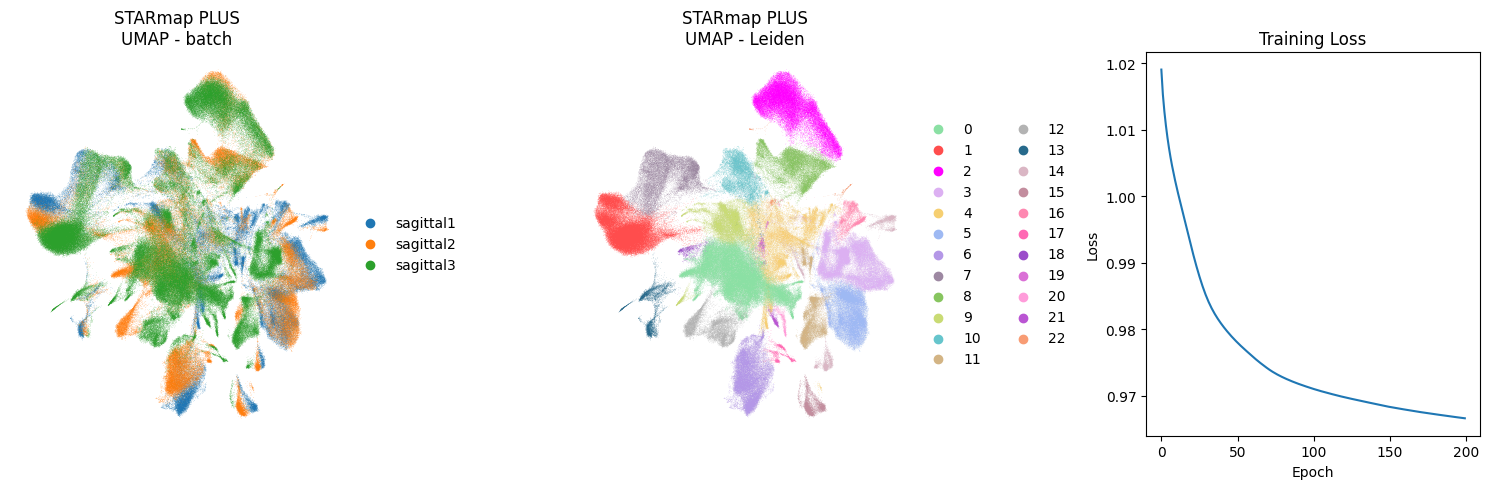

In [12]:
# Visualization
from SpaLP.utils import create_new_color_dict
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# UMAP with legend
latent_cluster_colors = create_new_color_dict(adata=adata, cat_key="SpaLP")
sc.pl.umap(adata=adata,color='batch',title='STARmap PLUS\nUMAP - batch',size=0.3,colorbar_loc=None,frameon=False,ax=axes[0],show=False)
sc.pl.umap(adata=adata,color='SpaLP',title='STARmap PLUS\nUMAP - Leiden',size=0.3,colorbar_loc=None,frameon=False,palette=latent_cluster_colors,ax=axes[1],show=False)

# Training loss
axes[2].plot(losses)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('Training Loss')

plt.tight_layout()
plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig4/Fig4_STARmapPLUS_UMAP.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
adata

AnnData object with n_obs × n_vars = 422673 × 1022
    obs: 'Main_molecular_cell_type', 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'batch', 'SpaLP', 'Kmeans_SpaLP'
    uns: 'neighbors', 'leiden', 'umap', 'batch_colors', 'SpaLP_colors'
    obsm: 'spatial', 'feat', 'SpaLP', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

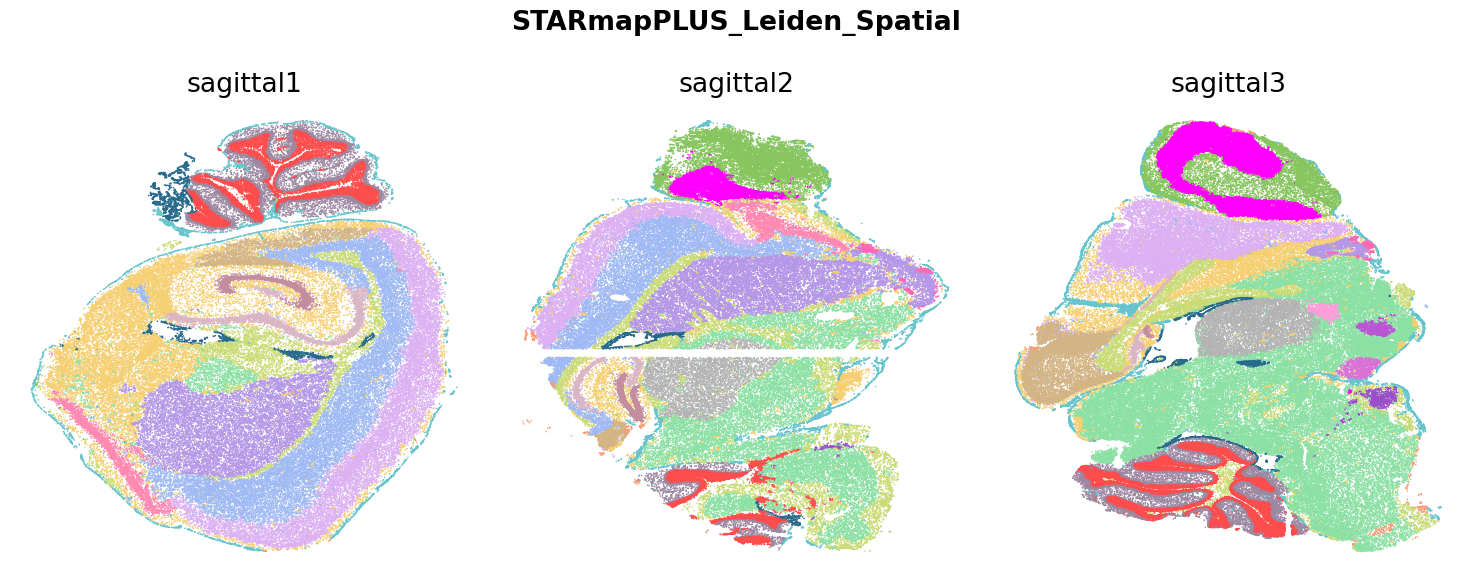

In [14]:
import matplotlib.pyplot as plt
from SpaLP.utils import create_new_color_dict
plt.rcParams['figure.figsize'] = (6,8)
plt.rcParams['font.size'] = 16
samples = adata.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(5 * len(samples), 6))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['batch'] == sample],title=sample,basis='spatial',color=['SpaLP'],legend_loc=None,frameon=False,colorbar_loc=None,ax=axs[idx],palette=latent_cluster_colors,show=False,size=5)

plt.suptitle('STARmapPLUS_Leiden_Spatial', fontweight='bold')
plt.tight_layout()
plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig4/Fig4_STARmapPLUS_spatial.png', dpi=150, bbox_inches='tight')
plt.show()

# Dataset 2: Within-platform integration (MERSCOPE)

In [15]:
# Load MERSCOPE data
adata=sc.read_h5ad('/home/dbj/SpaLA/Batch/MERSCOPE/merscope.h5ad')
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 734696 × 483
    obs: 'fov', 'volume', 'min_x', 'max_x', 'min_y', 'max_y', 'slice_id', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'ct'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'ct_colors', 'hvg', 'leiden', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'blank_genes', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [16]:
adata.obs['slice_id'].unique()
adata.obs['batch']=adata.obs['slice_id']

In [17]:
# Preprocessing standardization  *******
import anndata as ad
start_time = time.time()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.scale(adata)
adata.obsm['feat']=adata.X
prep_time = time.time() - start_time

print(f"Spatial coords shape: {adata.obsm['spatial'].shape}")
print(f"Preprocessing standardization: {prep_time:.2f}s")

Spatial coords shape: (734696, 2)
Preprocessing standardization: 2.63s


In [18]:
# Set the hyperparameters  k=6
k=6
in_channels = adata.obsm['feat'].shape[1]
lr=0.001
epochs = 200
hidden_dim=64
print(f"Feature dimensions: {in_channels}")

Feature dimensions: 483


In [19]:
# Build neighbor graph  k=6
from SpaLP.utils import Graph
start_time = time.time()
#compute a separate spatial neighbor index matrix for each sample
graphs = []
for batch in adata.obs['batch'].unique():  #compute a separate spatial neighbor index matrix for each sample and combine them as disconnected components.
    a = adata[adata.obs['batch'] == batch].copy()
    graph = prepare_inputs(a, k=k, device=device)
    graphs.append(graph)

# combine disconnected components.
all_features = torch.cat([g.features for g in graphs], dim=0)
all_neighbor_idx = []
offset = 0
for g in graphs:
    all_neighbor_idx.append(g.neighbor_idx + offset)
    offset += g.features.shape[0]
all_neighbor_idx = torch.cat(all_neighbor_idx, dim=0)
graph = Graph(all_features, all_neighbor_idx)

prep_time = time.time() - start_time
print(f"Graph preparation: {prep_time:.2f}s")

Graph preparation: 3.16s


In [20]:
%%time
#runtime /GPU peak memory/CPU peak memory
start_time = time.time()
@measure_resources
def run_train():
    return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=7)#The default random seed for the SpaLP algorithm is 7.
embedding, losses = run_train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f}s")

# Store embeddings
adata.obsm['SpaLP'] = embedding

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:46<00:00,  4.26it/s, Epoch=199, Loss=0.9283]


CPU peak memory: 1.49 GB
GPU peak memory: 19.90 GB
Training time: 49.79s
CPU times: user 47.6 s, sys: 1.14 s, total: 48.7 s
Wall time: 49.8 s


In [26]:
%%time
# Clustering and UMAP
start_time = time.time()
sc.pp.neighbors(adata, use_rep="SpaLP")
sc.tl.leiden(adata, resolution=0.35,key_added='SpaLP')#The clustering results save in adata.obs['SpaLP']
elapsed = time.time() - start_time
print(f"Leiden time: {int(elapsed//60)}min {elapsed%60:.2f}s")

t0 = time.time()
sc.tl.umap(adata)
elapsed = time.time() - t0
print(f"UMAP time: {int(elapsed//60)}min {elapsed%60:.2f}s")
print(f"Found {len(adata.obs['SpaLP'].unique())} clusters")

Leiden time: 33min 19.87s
UMAP time: 7min 37.35s
Found 31 clusters
CPU times: user 1h 59min 48s, sys: 49min 32s, total: 2h 49min 21s
Wall time: 40min 57s


In [27]:
%%time
# KMeans time
from sklearn.cluster import KMeans
leiden_cluster=len(adata.obs['SpaLP'].unique())
kmeans = KMeans(n_clusters=leiden_cluster, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['Kmeans_SpaLP']=labels.astype(str)  #The clustering results save in adata.obs['Kmeans_SpaLP']

CPU times: user 1min 22s, sys: 2min 48s, total: 4min 10s
Wall time: 4.41 s


In [28]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig4MERSCOPE.h5ad',compression='gzip')  #Save the embedding for rapid single-cell (GPU-scanpy) analysis and Batch effect evaluation (scib_metrics).

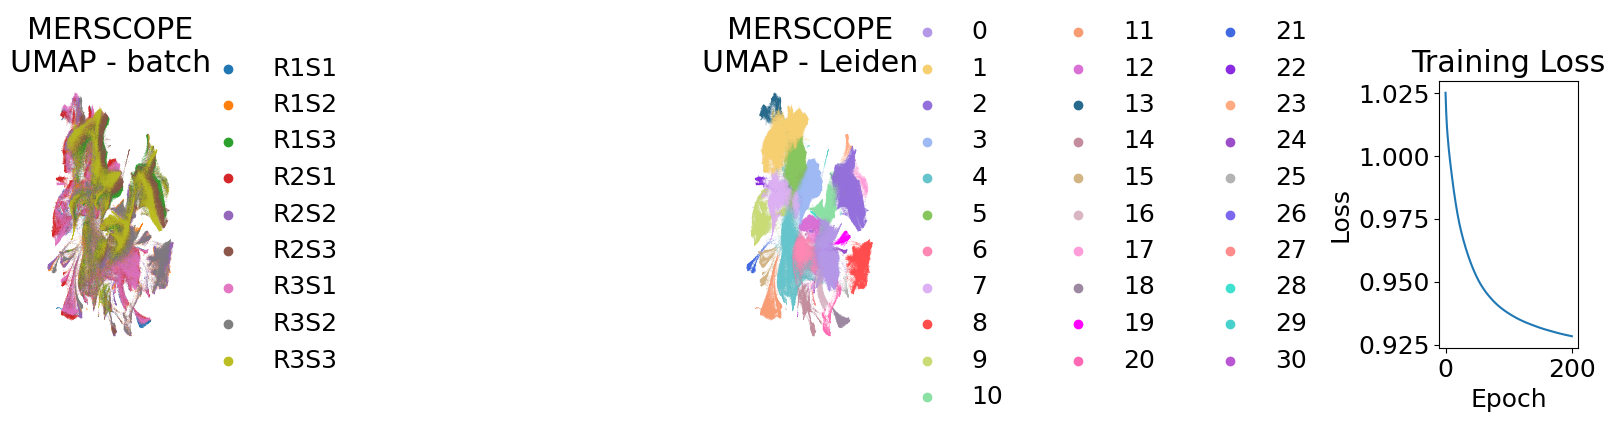

In [29]:
from SpaLP.utils import create_new_color_dict
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
# UMAP with legend
latent_cluster_colors = create_new_color_dict(adata=adata, cat_key="SpaLP")
sc.pl.umap(adata=adata,color='batch',title='MERSCOPE\nUMAP - batch',size=0.3,colorbar_loc=None,frameon=False,ax=axes[0],show=False)
sc.pl.umap(adata=adata,color='SpaLP',title='MERSCOPE\nUMAP - Leiden',size=0.3,colorbar_loc=None,frameon=False,palette=latent_cluster_colors,ax=axes[1],show=False)

# Training loss
axes[2].plot(losses)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('Training Loss')

plt.tight_layout()
plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig4/Fig4_MERSCOPE_UMAP.png', dpi=150, bbox_inches='tight')
plt.show()

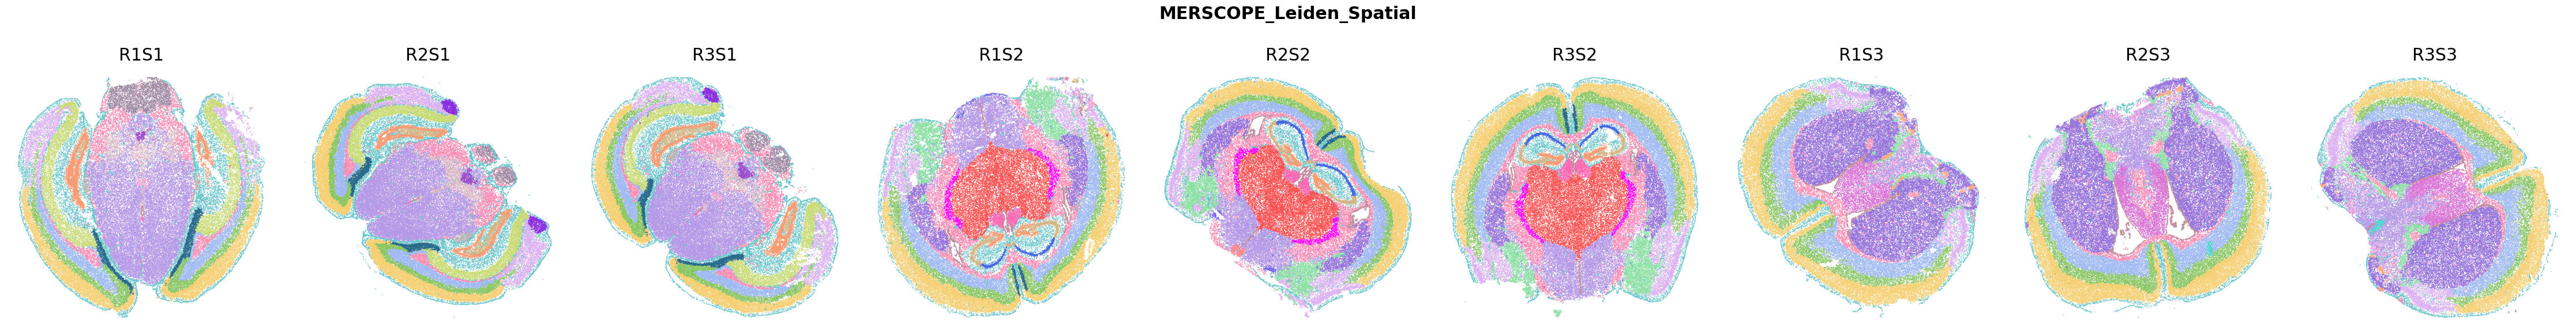

In [30]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 18
samples = adata.obs['slice_id'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(5 * len(samples), 6))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['slice_id'] == sample],title=sample,basis='spatial',color=['SpaLP'],legend_loc=None,frameon=False,colorbar_loc=None,ax=axs[idx],palette=latent_cluster_colors,show=False,size=5)
    
plt.suptitle('MERSCOPE_Leiden_Spatial', fontweight='bold')
plt.tight_layout()
plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig4/Fig4_MERSCOPE_spatial.png', dpi=150, bbox_inches='tight')
plt.show()

# Dataset 3: Within-platform integration (VisiumHD)

In [32]:
# Load VisiumHD data
adata1=sc.read_h5ad('/home/dbj/SpaLP/Tutorialdata/FreshFrozenVisiumHDP1.h5ad')
adata1.var_names_make_unique()
adata1.obs['batch']='P1'
adata2=sc.read_h5ad('/home/dbj/SpaLP/Tutorialdata/FFIFVisiumHDP2.h5ad')
adata2.var_names_make_unique()
adata2.obs['batch']='P2'
adata1,adata2

(AnnData object with n_obs × n_vars = 553820 × 18085
     obs: 'in_tissue', 'array_row', 'array_col', 'batch'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 679294 × 18085
     obs: 'in_tissue', 'array_row', 'array_col', 'batch'
     var: 'gene_ids', 'feature_types', 'genome'
     uns: 'spatial'
     obsm: 'spatial')

In [33]:
sc.pp.highly_variable_genes(adata1, n_top_genes=2000, flavor='seurat_v3')
adata1 = adata1[:,adata1.var.highly_variable]
sc.pp.highly_variable_genes(adata2, n_top_genes=2000, flavor='seurat_v3')
adata2 = adata2[:,adata2.var.highly_variable]
adata_batch_list = [adata1,adata2]
adata = ad.concat(adata_batch_list, join="inner")

In [34]:
# Preprocessing standardization  *******
import anndata as ad
start_time = time.time()
adatas = []
for batch in adata.obs['batch'].unique():  #Preprocess each slice independently and then merge them.
    a = adata[adata.obs['batch'] == batch].copy()
    sc.pp.normalize_total(a,inplace=True)
    sc.pp.log1p(a)
    sc.pp.scale(a)
    sc.pp.filter_cells(a,min_genes=1)
    adatas.append(a)

adata = ad.concat(adatas, join="inner")
adata.obsm['feat']=adata.X
prep_time = time.time() - start_time

print(f"Spatial coords shape: {adata.obsm['spatial'].shape}")
print(f"Preprocessing standardization: {prep_time:.2f}s")

Spatial coords shape: (1216483, 2)
Preprocessing standardization: 15.52s


In [35]:
# Set the hyperparameters  k=4
k=4
in_channels = adata.obsm['feat'].shape[1]
lr=0.001
epochs = 200
hidden_dim=32
print(f"Feature dimensions: {in_channels}")

Feature dimensions: 1168


In [36]:
# Build neighbor graph  k=6
from SpaLP.utils import Graph
start_time = time.time()
#compute a separate spatial neighbor index matrix for each sample
graphs = []
for batch in adata.obs['batch'].unique():  #compute a separate spatial neighbor index matrix for each sample and combine them as disconnected components.
    a = adata[adata.obs['batch'] == batch].copy()
    graph = prepare_inputs(a, k=k, device=device)
    graphs.append(graph)

# combine disconnected components.
all_features = torch.cat([g.features for g in graphs], dim=0)
all_neighbor_idx = []
offset = 0
for g in graphs:
    all_neighbor_idx.append(g.neighbor_idx + offset)
    offset += g.features.shape[0]
all_neighbor_idx = torch.cat(all_neighbor_idx, dim=0)
graph = Graph(all_features, all_neighbor_idx)

prep_time = time.time() - start_time
print(f"Graph preparation: {prep_time:.2f}s")

Graph preparation: 7.43s


In [37]:
%%time
#runtime /GPU peak memory/CPU peak memory
start_time = time.time()
@measure_resources
def run_train():
    return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=7)#The default random seed for the SpaLP algorithm is 7.
embedding, losses = run_train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f}s")

# Store embeddings
adata.obsm['SpaLP'] = embedding

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:43<00:00,  4.56it/s, Epoch=199, Loss=0.9726]


CPU peak memory: 5.43 GB
GPU peak memory: 35.31 GB
Training time: 49.46s
CPU times: user 45 s, sys: 3.23 s, total: 48.2 s
Wall time: 49.5 s


In [38]:
%%time
# Clustering and UMAP
start_time = time.time()
sc.pp.neighbors(adata, use_rep="SpaLP")
sc.tl.leiden(adata, resolution=0.2,key_added='SpaLP')#The clustering results save in adata.obs['SpaLP']
elapsed = time.time() - start_time
print(f"Leiden time: {int(elapsed//60)}min {elapsed%60:.2f}s")

t0 = time.time()
sc.tl.umap(adata)
elapsed = time.time() - t0
print(f"UMAP time: {int(elapsed//60)}min {elapsed%60:.2f}s")
print(f"Found {len(adata.obs['SpaLP'].unique())} clusters")

Leiden time: 192min 21.13s
UMAP time: 14min 43.81s
Found 8 clusters
CPU times: user 6h 49min 37s, sys: 2h 17min 36s, total: 9h 7min 14s
Wall time: 3h 27min 4s


In [39]:
%%time
# KMeans time
from sklearn.cluster import KMeans
leiden_cluster=len(adata.obs['SpaLP'].unique())
kmeans = KMeans(n_clusters=leiden_cluster, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['Kmeans_SpaLP']=labels.astype(str)  #The clustering results save in adata.obs['Kmeans_SpaLP']

CPU times: user 34.8 s, sys: 1min 5s, total: 1min 40s
Wall time: 2.16 s


In [40]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig4VisiumHD.h5ad',compression='gzip')  #Save the embedding for rapid single-cell (GPU-scanpy) analysis and Batch effect evaluation (scib_metrics).

In [ ]:
from SpaLP.utils import create_new_color_dict
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
# UMAP with legend
latent_cluster_colors = create_new_color_dict(adata=adata, cat_key="SpaLP")
sc.pl.umap(adata=adata,color='batch',title='VisiumHD\nUMAP - batch',size=0.3,colorbar_loc=None,frameon=False,ax=axes[0],show=False)
sc.pl.umap(adata=adata,color='SpaLP',title='VisiumHD\nUMAP - Leiden',size=0.3,colorbar_loc=None,frameon=False,palette=latent_cluster_colors,ax=axes[1],show=False)

# Training loss
axes[2].plot(losses)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('Training Loss')

plt.tight_layout()
#plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig4/Fig4_VisiumHD_UMAP.png', dpi=150, bbox_inches='tight')
plt.show()

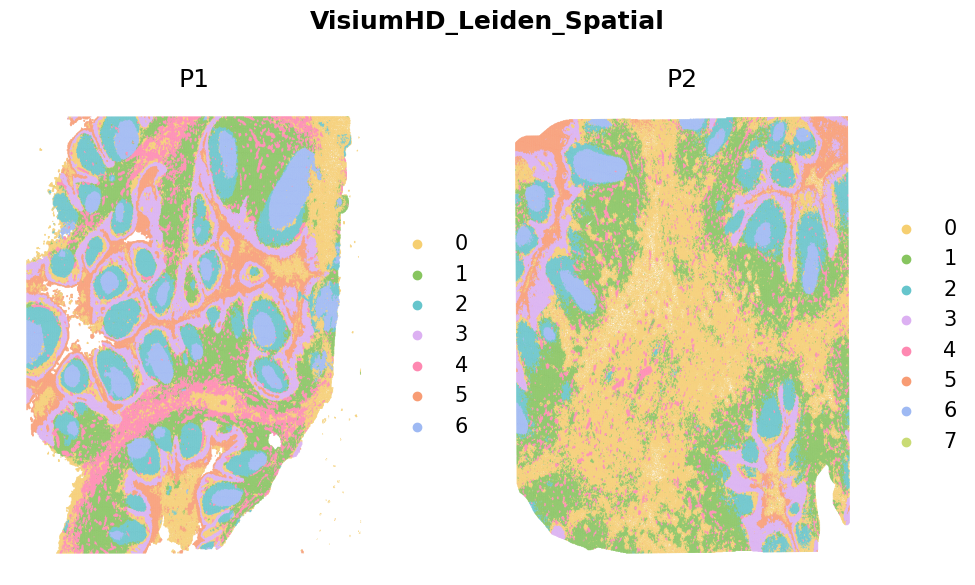

In [8]:
adata.obsm['spatial'][:, 1] = -adata.obsm['spatial'][:, 1]
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15
samples = adata.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(5 * len(samples), 6))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['batch'] == sample],title=sample,basis='spatial',color=['SpaLP'],legend_loc=None,frameon=False,colorbar_loc=None,ax=axs[idx],palette=latent_cluster_colors,show=False,size=1)
    
plt.suptitle('VisiumHD_Leiden_Spatial', fontweight='bold')
plt.tight_layout()
#plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig4/Fig4_VisiumHD_spatial.png', dpi=150, bbox_inches='tight')
plt.show()

# Dataset 4: Cross-platform integration (CosMx,STARmapPLUS,MERFISH)

In [54]:
adata_batch1=sc.read_h5ad("/home/dbj/SpaLA/Batch/MERFISH.h5ad")
adata_batch1.obs['batch']='MERFISH'
adata_batch2=sc.read_h5ad("/home/dbj/SpaLA/Batch/STARmapPLUS.h5ad")
adata_batch2.obs['batch']='STARmapPLUS'
adata_batch3=sc.read_h5ad("/home/dbj/SpaLA/Batch/CosMx.h5ad")
adata_batch3.obs['batch']='CosMx'
adata_list=[adata_batch1,adata_batch2,adata_batch3]
adata = ad.concat(adata_list, join="inner")

In [55]:
# Preprocessing standardization  *******
import anndata as ad
start_time = time.time()
adatas = []
for batch in adata.obs['batch'].unique():  #Preprocess each slice independently and then merge them.
    a = adata[adata.obs['batch'] == batch].copy()
    sc.pp.normalize_total(a,inplace=True)
    sc.pp.log1p(a)
    sc.pp.scale(a)
    adatas.append(a)

adata = ad.concat(adatas, join="inner")
adata.obsm['feat']=adata.X
prep_time = time.time() - start_time

print(f"Spatial coords shape: {adata.obsm['spatial'].shape}")
print(f"Preprocessing standardization: {prep_time:.2f}s")

Spatial coords shape: (140951, 2)
Preprocessing standardization: 0.15s


In [56]:
# Set the hyperparameters  k=10
k=10
in_channels = adata.obsm['feat'].shape[1]
lr=0.001
epochs = 200
hidden_dim=32
print(f"Feature dimensions: {in_channels}")

Feature dimensions: 87


In [57]:
# Build neighbor graph  k=10
from SpaLP.utils import Graph
start_time = time.time()
#compute a separate spatial neighbor index matrix for each sample
graphs = []
for batch in adata.obs['batch'].unique():  #compute a separate spatial neighbor index matrix for each sample and combine them as disconnected components.
    a = adata[adata.obs['batch'] == batch].copy()
    graph = prepare_inputs(a, k=k, device=device)
    graphs.append(graph)

# combine disconnected components.
all_features = torch.cat([g.features for g in graphs], dim=0)
all_neighbor_idx = []
offset = 0
for g in graphs:
    all_neighbor_idx.append(g.neighbor_idx + offset)
    offset += g.features.shape[0]
all_neighbor_idx = torch.cat(all_neighbor_idx, dim=0)
graph = Graph(all_features, all_neighbor_idx)

prep_time = time.time() - start_time
print(f"Graph preparation: {prep_time:.2f}s")

Graph preparation: 0.24s


In [58]:
%%time
#runtime /GPU peak memory/CPU peak memory
start_time = time.time()
@measure_resources
def run_train():
    return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=7)#The default random seed for the SpaLP algorithm is 7.
embedding, losses = run_train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f}s")

# Store embeddings
adata.obsm['SpaLP'] = embedding

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 29.63it/s, Epoch=199, Loss=0.9348]


CPU peak memory: 0.00 GB
GPU peak memory: 2.69 GB
Training time: 8.91s
CPU times: user 7.02 s, sys: 658 ms, total: 7.68 s
Wall time: 8.91 s


In [59]:
%%time
# Clustering and UMAP
start_time = time.time()
sc.pp.neighbors(adata, use_rep="SpaLP")
sc.tl.leiden(adata, resolution=0.5,key_added='SpaLP')#The clustering results save in adata.obs['SpaLP']
elapsed = time.time() - start_time
print(f"Leiden time: {int(elapsed//60)}min {elapsed%60:.2f}s")

t0 = time.time()
sc.tl.umap(adata)
elapsed = time.time() - t0
print(f"UMAP time: {int(elapsed//60)}min {elapsed%60:.2f}s")
print(f"Found {len(adata.obs['SpaLP'].unique())} clusters")

Leiden time: 2min 56.93s
UMAP time: 0min 59.80s
Found 22 clusters
CPU times: user 9min 16s, sys: 4min 32s, total: 13min 48s
Wall time: 3min 56s


In [60]:
%%time
# KMeans time
from sklearn.cluster import KMeans
leiden_cluster=len(adata.obs['SpaLP'].unique())
kmeans = KMeans(n_clusters=leiden_cluster, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['Kmeans_SpaLP']=labels.astype(str)  #The clustering results save in adata.obs['Kmeans_SpaLP']

CPU times: user 10.7 s, sys: 11.2 s, total: 21.9 s
Wall time: 543 ms


In [61]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig4Cross-platform-mouse-brain.h5ad',compression='gzip')  #Save the embedding for rapid single-cell (GPU-scanpy) analysis and Batch effect evaluation (scib_metrics).

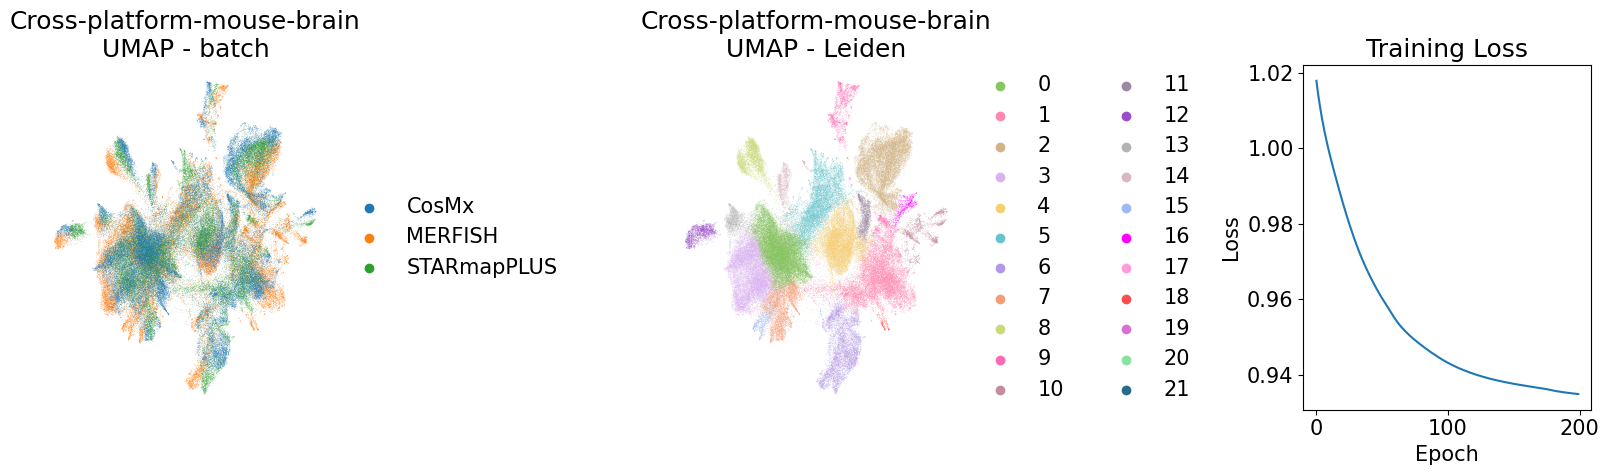

In [65]:
from SpaLP.utils import create_new_color_dict
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
# UMAP with legend
latent_cluster_colors = create_new_color_dict(adata=adata, cat_key="SpaLP")
sc.pl.umap(adata=adata,color='batch',title='Cross-platform-mouse-brain\nUMAP - batch',size=0.4,colorbar_loc=None,frameon=False,ax=axes[0],show=False)
sc.pl.umap(adata=adata,color='SpaLP',title='Cross-platform-mouse-brain\nUMAP - Leiden',size=0.4,colorbar_loc=None,frameon=False,palette=latent_cluster_colors,ax=axes[1],show=False)

# Training loss
axes[2].plot(losses)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('Training Loss')

plt.tight_layout()
plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig4/Fig4_Cross-platform-mouse-brain_UMAP.png', dpi=150, bbox_inches='tight')
plt.show()

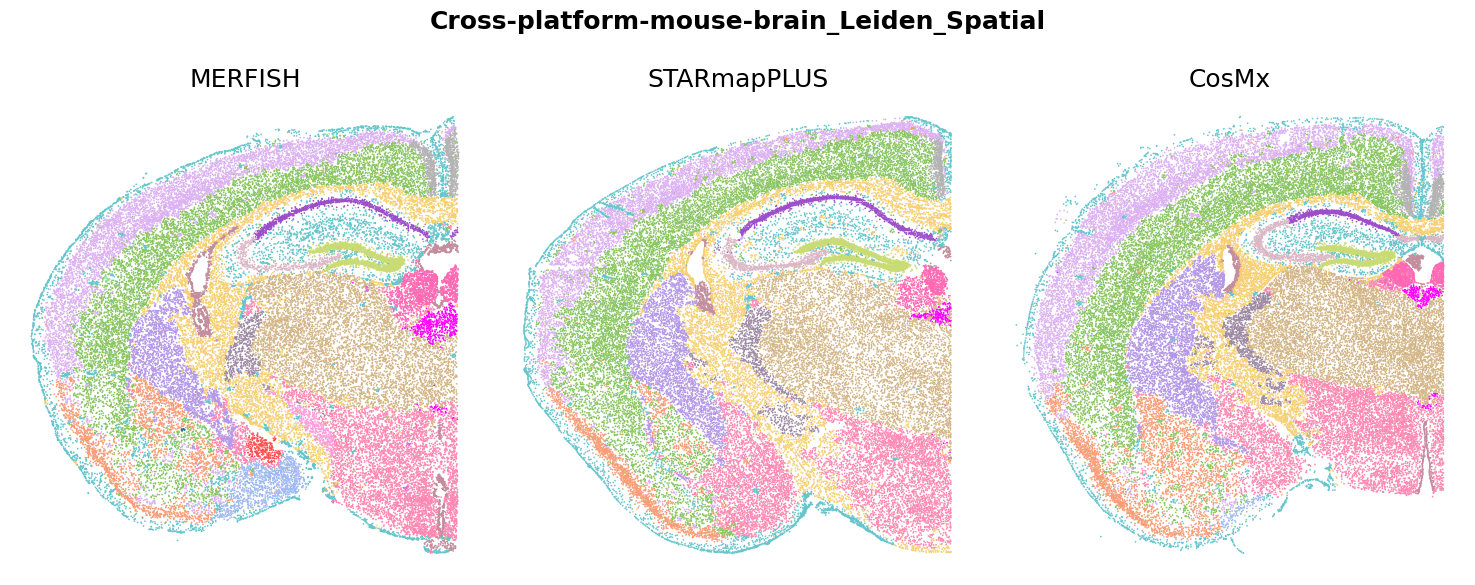

In [64]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15
samples = adata.obs['batch'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(5 * len(samples), 6))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['batch'] == sample],title=sample,basis='spatial',color=['SpaLP'],legend_loc=None,frameon=False,colorbar_loc=None,ax=axs[idx],palette=latent_cluster_colors,show=False,size=6)
    
plt.suptitle('Cross-platform-mouse-brain_Leiden_Spatial', fontweight='bold')
plt.tight_layout()
plt.savefig('/home/dbj/SpaLP/gittest/repoduced/Fig4/Fig4_Cross-platform-mouse-brain_spatial.png', dpi=150, bbox_inches='tight')
plt.show()

# Dataset 5: Cross-platform Human Colorectal Cancer (CosMx,Xenium,VisiumHD)

In [66]:
adata1=sc.read_h5ad('/home/dbj/SpaLA/Batch/BatchCRC/CosMx.h5ad')
adata1.var_names_make_unique()
adata1.obs['batch']='CosMx'

adata2=sc.read_h5ad('/home/dbj/SpaLA/Batch/BatchCRC/Xeniump1.h5ad')
adata2.var_names_make_unique()
adata2.obs['batch']='Xenium P1'

adata3=sc.read_visium('/home/dbj/SpatialSLM/datasets/GraphST/visiumHD/Human_Colon_Cancer_P1/binned_outputs/square_008um')
adata3.var_names_make_unique()
adata3.obs['batch']='VisiumHD P1'

adata4=sc.read_visium('/home/dbj/SpatialSLM/datasets/GraphST/visiumHD/Human_Colon_Cancer_P2/square_008um')
adata4.var_names_make_unique()
adata4.obs['batch']='VisiumHD P2'

adata5=sc.read_visium('/home/dbj/SpatialSLM/datasets/GraphST/visiumHD/P5/square_008um')
adata5.var_names_make_unique()
adata5.obs['batch']='VisiumHD P5'

adata_batch_list = [adata1,adata2,adata3,adata4,adata5]
adata = ad.concat(adata_batch_list, join="inner")
sc.pp.filter_cells(adata,min_genes=2)

In [67]:
# Preprocessing standardization  *******
import anndata as ad
start_time = time.time()
adatas = []
for batch in adata.obs['batch'].unique():  #Preprocess each slice independently and then merge them.
    a = adata[adata.obs['batch'] == batch].copy()
    sc.pp.normalize_total(a,inplace=True)
    sc.pp.log1p(a)
    sc.pp.scale(a)
    adatas.append(a)

adata = ad.concat(adatas, join="inner")
adata.obsm['feat']=adata.X
prep_time = time.time() - start_time

print(f"Spatial coords shape: {adata.obsm['spatial'].shape}")
print(f"Preprocessing standardization: {prep_time:.2f}s")

Spatial coords shape: (2127707, 2)
Preprocessing standardization: 8.99s


In [68]:
# Set the hyperparameters  k=4
k=4
in_channels = adata.obsm['feat'].shape[1]
lr=0.001
epochs = 200
hidden_dim=32
print(f"Feature dimensions: {in_channels}")

Feature dimensions: 329


In [69]:
# Build neighbor graph  k=4
from SpaLP.utils import Graph
start_time = time.time()
#compute a separate spatial neighbor index matrix for each sample
graphs = []
for batch in adata.obs['batch'].unique():  #compute a separate spatial neighbor index matrix for each sample and combine them as disconnected components.
    a = adata[adata.obs['batch'] == batch].copy()
    graph = prepare_inputs(a, k=k, device=device)
    graphs.append(graph)

# combine disconnected components.
all_features = torch.cat([g.features for g in graphs], dim=0)
all_neighbor_idx = []
offset = 0
for g in graphs:
    all_neighbor_idx.append(g.neighbor_idx + offset)
    offset += g.features.shape[0]
all_neighbor_idx = torch.cat(all_neighbor_idx, dim=0)
graph = Graph(all_features, all_neighbor_idx)

prep_time = time.time() - start_time
print(f"Graph preparation: {prep_time:.2f}s")

Graph preparation: 7.46s


In [70]:
%%time
#runtime /GPU peak memory/CPU peak memory
start_time = time.time()
@measure_resources
def run_train():
    return train_spalp(graph, in_channels, hidden_dim, epochs, lr, device, seed=7)#The default random seed for the SpaLP algorithm is 7.
embedding, losses = run_train()
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f}s")

# Store embeddings
adata.obsm['SpaLP'] = embedding

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:57<00:00,  3.49it/s, Epoch=199, Loss=0.9437]


CPU peak memory: 2.75 GB
GPU peak memory: 21.96 GB
Training time: 61.84s
CPU times: user 57.9 s, sys: 2.57 s, total: 1min
Wall time: 1min 1s


In [73]:
%%time
# KMeans time
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=9, random_state=2024) 
labels = kmeans.fit_predict(adata.obsm['SpaLP'])
adata.obs['Kmeans_SpaLP']=labels.astype(str)  #The clustering results save in adata.obs['Kmeans_SpaLP']

CPU times: user 49.3 s, sys: 1min 42s, total: 2min 32s
Wall time: 3.27 s


## Obtaining the Leiden and UMAP results using rapid single cell (GPU-scanpy)

In [72]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/repoduced/result/Fig4Cross-platform-HumanColorectalCancer.h5ad',compression='gzip')  #Save the embedding for rapid single-cell (GPU-scanpy) analysis and Batch effect evaluation (scib_metrics).